# Panan005 Bottom salinity

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39421/status,
Dashboard: /proxy/39421/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38039,Workers: 28
Dashboard: /proxy/39421/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:43243,Total threads: 1
Dashboard: /proxy/46233/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:34073,


In [4]:
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/outpu*/*.ocean_month_z.nc'))[120:]
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-005-zstar-ssp126-MW-only/outpu*/*.ocean_month_z.nc'))[:60]

In [5]:
## Creating shelf mask another way

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [7]:
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output239/20101201.ocean_static.nc')['deptho']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_005')

In [8]:
#Time variant variables
def preprocess(ds):
    ds = ds['so'].where(shelf_mask == 1)
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [9]:
#Time slicing
cont = cont.sel(time=slice('2001-01-01','2010-12-31'))
melt = melt.sel(time=slice('2001-01-01','2010-12-31'))

In [10]:
#Time invariant variables
areaC = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output239/20101201.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])
areaM = xr.open_dataset('/g/data/g40/akm157/model_output/mom6-panan/panant-005-zstar-ssp126-MW-only/output120/20010101.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])

In [11]:
# Salinity variable
saltC = cont['so']
saltM = melt['so']

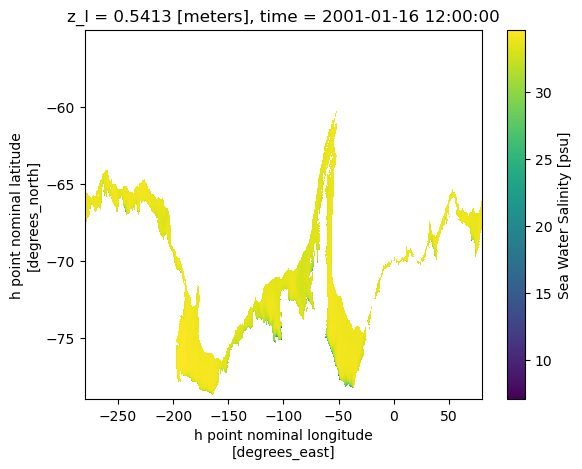

In [12]:
# Checking shelf mask
saltC.isel(z_l=0).isel(time=0).plot()

### Creating the regions

In [13]:
## Weddell Sea
# Saved as _W
lat_slice_W = slice(-78,-71)
lon_slice_W = slice(-64.95,-44.95)

## Ross Sea
# Saved as _R
lat_slice_R = slice(-78,-71.5)
lon_slice_R = slice(-200,-175)

## Adelie Coast
# Saved as _A
lat_slice_A = slice(-69,-64.5)
lon_slice_A = slice(45,79)

## Prydz Bay
# Saved as _P
lat_slice_P = slice(-69,-65)
lon_slice_P = slice(-235,-205)

In [14]:
# Correcting area
areaC_corr = areaC*(saltC.isel(time=0,z_l=0)*0 +1)
areaM_corr = areaM*(saltM.isel(time=0,z_l=0)*0 +1)

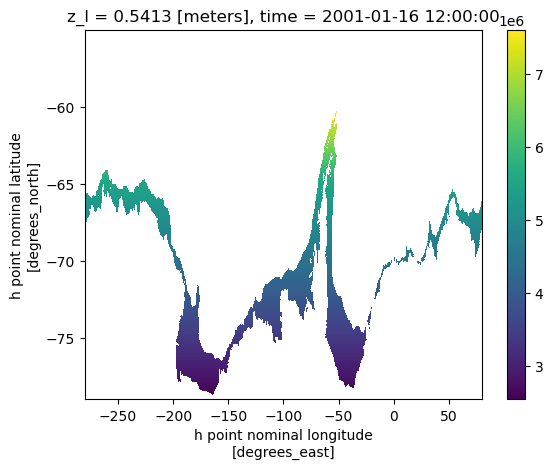

In [15]:
areaC_corr.plot()

## Bottom mask

In [16]:
bottom_mask_saltC = saltC.where(~np.isfinite(saltC.shift({'z_l': -1})))
bottom_mask_saltC = ~np.isnan(bottom_mask_saltC)

In [17]:
bottom_mask_saltM = saltM.where(~np.isfinite(saltM.shift({'z_l': -1})))
bottom_mask_saltM = ~np.isnan(bottom_mask_saltM)

In [18]:
botsalt_cont = saltC.where(bottom_mask_saltC).sum(dim='z_l')
botsalt_pert = saltM.where(bottom_mask_saltM).sum(dim='z_l')

#### Time series

In [19]:
# Restricting to regions
botsalt_cont_W = botsalt_cont.sel(yh=lat_slice_W,xh=lon_slice_W)
botsalt_pert_W = botsalt_pert.sel(yh=lat_slice_W,xh=lon_slice_W)

botsalt_cont_R = botsalt_cont.sel(yh=lat_slice_R,xh=lon_slice_R)
botsalt_pert_R = botsalt_pert.sel(yh=lat_slice_R,xh=lon_slice_R)

botsalt_cont_A = botsalt_cont.sel(yh=lat_slice_A,xh=lon_slice_A)
botsalt_pert_A = botsalt_pert.sel(yh=lat_slice_A,xh=lon_slice_A)

botsalt_cont_P = botsalt_cont.sel(yh=lat_slice_P,xh=lon_slice_P)
botsalt_pert_P = botsalt_pert.sel(yh=lat_slice_P,xh=lon_slice_P)

In [20]:
# Spatial averages
botsalt_cont_W_time = (areaC_corr * botsalt_cont_W).sum(['xh', 'yh']) / areaC_corr.sum(['xh', 'yh'])
botsalt_pert_W_time = (areaM_corr * botsalt_pert_W).sum(['xh', 'yh']) / areaM_corr.sum(['xh', 'yh'])

botsalt_cont_R_time = (areaC_corr * botsalt_cont_R).sum(['xh', 'yh']) / areaC_corr.sum(['xh', 'yh'])
botsalt_pert_R_time = (areaM_corr * botsalt_pert_R).sum(['xh', 'yh']) / areaM_corr.sum(['xh', 'yh'])

botsalt_cont_A_time = (areaC_corr * botsalt_cont_A).sum(['xh', 'yh']) / areaC_corr.sum(['xh', 'yh'])
botsalt_pert_A_time = (areaM_corr * botsalt_pert_A).sum(['xh', 'yh']) / areaM_corr.sum(['xh', 'yh'])

botsalt_cont_P_time = (areaC_corr * botsalt_cont_P).sum(['xh', 'yh']) / areaC_corr.sum(['xh', 'yh'])
botsalt_pert_P_time = (areaM_corr * botsalt_pert_P).sum(['xh', 'yh']) / areaM_corr.sum(['xh', 'yh'])

In [21]:
# Check shape
botsalt_cont_W_time

<xarray.DataArray (time: 120)> Size: 480B
dask.array<truediv, shape=(120,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    z_l      float64 8B 0.5413
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00

In [22]:
botsalt_cont_W_time = botsalt_cont_W_time.load()
botsalt_pert_W_time = botsalt_pert_W_time.load()

In [23]:
botsalt_cont_R_time = botsalt_cont_R_time.load()
botsalt_pert_R_time = botsalt_pert_R_time.load()

In [24]:
botsalt_cont_A_time = botsalt_cont_A_time.load()
botsalt_pert_A_time = botsalt_pert_A_time.load()

In [25]:
botsalt_cont_P_time = botsalt_cont_P_time.load()
botsalt_pert_P_time = botsalt_pert_P_time.load()

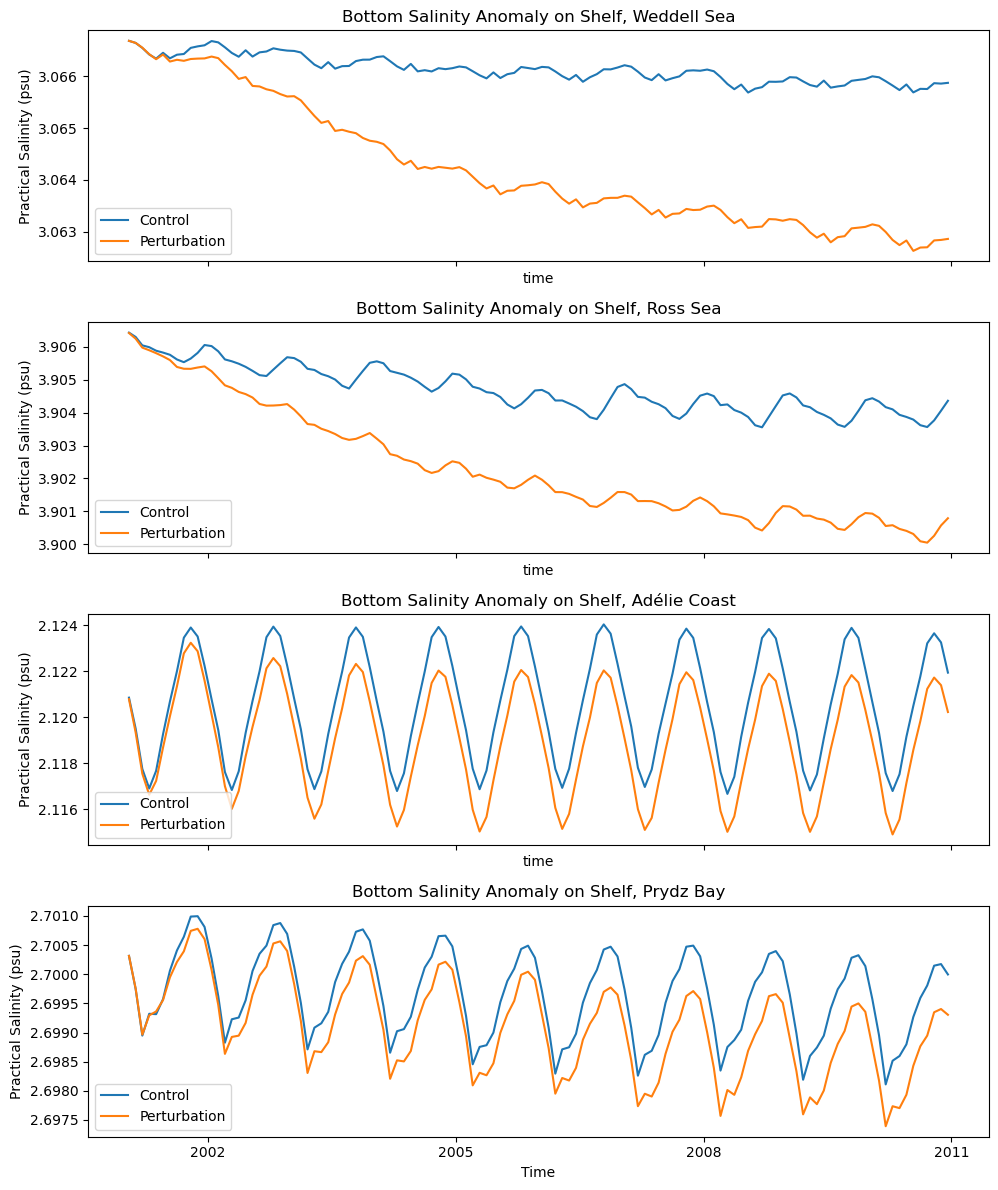

In [26]:
fig, axes = plt.subplots(
    nrows=4, ncols=1,
    sharex=True, figsize=(10, 12)
)

# First subplot: W_time
botsalt_cont_W_time.plot(ax=axes[0], label="Control")
botsalt_pert_W_time.plot(ax=axes[0], label="Perturbation")
axes[0].set_ylabel("Practical Salinity (psu)")
axes[0].legend(loc="lower left")
axes[0].set_title("Bottom Salinity Anomaly on Shelf, Weddell Sea")

# Second subplot: R_time
botsalt_cont_R_time.plot(ax=axes[1], label="Control")
botsalt_pert_R_time.plot(ax=axes[1], label="Perturbation")
axes[1].set_ylabel("Practical Salinity (psu)")
axes[1].legend(loc="lower left")
axes[1].set_title("Bottom Salinity Anomaly on Shelf, Ross Sea")

# Third subplot: A_time
botsalt_cont_A_time.plot(ax=axes[2], label="Control")
botsalt_pert_A_time.plot(ax=axes[2], label="Perturbation")
axes[2].set_ylabel("Practical Salinity (psu)")
axes[2].legend(loc="lower left")
axes[2].set_title("Bottom Salinity Anomaly on Shelf, Adélie Coast")

# Fourth subplot: P_time
botsalt_cont_P_time.plot(ax=axes[3], label="Control")
botsalt_pert_P_time.plot(ax=axes[3], label="Perturbation")
axes[3].set_ylabel("Practical Salinity (psu)")
axes[3].legend(loc="lower left")
axes[3].set_title("Bottom Salinity Anomaly on Shelf, Prydz Bay")

# Common X‑axis label
axes[-1].set_xlabel("Time")

# Adjust layout
plt.tight_layout()
plt.show()

In [27]:
botsalt_anom_W_time = botsalt_pert_W_time - botsalt_cont_W_time
botsalt_anom_W_time = botsalt_anom_W_time.load()
botsalt_anom_W_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_W_pan005.nc')

In [28]:
botsalt_anom_R_time = botsalt_pert_R_time - botsalt_cont_R_time
botsalt_anom_R_time = botsalt_anom_R_time.load()
botsalt_anom_R_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_R_pan005.nc')

In [29]:
botsalt_anom_A_time = botsalt_pert_A_time - botsalt_cont_A_time
botsalt_anom_A_time = botsalt_anom_A_time.load()
botsalt_anom_A_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_A_pan005.nc')

In [30]:
botsalt_anom_P_time = botsalt_pert_P_time - botsalt_cont_P_time
botsalt_anom_P_time = botsalt_anom_P_time.load()
botsalt_anom_P_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/botsalt_anom_P_pan005.nc')

#### Plotting all

Text(0.5, 1.0, 'Pan005 Time Series of Bottom Salinity on Shelf, AABW formation regions')

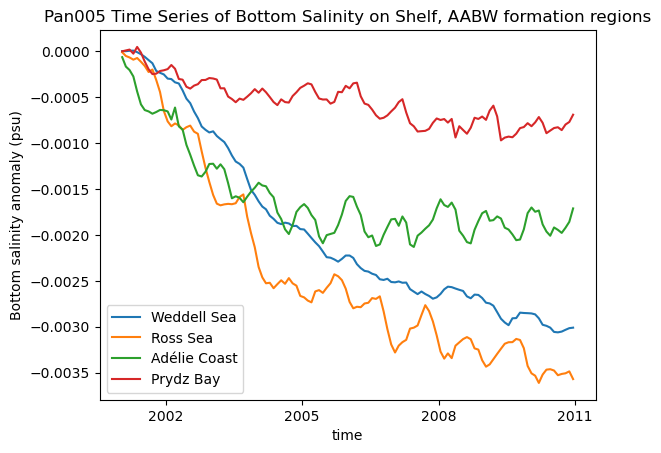

In [31]:
botsalt_anom_W_time.plot(label="Weddell Sea")
botsalt_anom_R_time.plot(label="Ross Sea")
botsalt_anom_A_time.plot(label="Adélie Coast")
botsalt_anom_P_time.plot(label="Prydz Bay")
plt.ylabel("Bottom salinity anomaly (psu)")
plt.legend(loc="lower left")
plt.title("Pan005 Time Series of Bottom Salinity on Shelf, AABW formation regions")

## Comparing between models